In [1]:
Sys.Date()

[1] "2020-05-21"

In [2]:
library(tidyverse)
library(Matrix)
library(extrafont)
library(gridExtra)

── Attaching packages ────────────────────────────────── tidyverse 1.3.0.9000 ──

✔ ggplot2 3.3.0.9000      ✔ purrr   0.3.4.9000 
✔ tibble  3.0.1.9000      ✔ dplyr   0.8.99.9003
✔ tidyr   1.1.0.9000      ✔ stringr 1.4.0.9000 
✔ readr   1.3.1.9000      ✔ forcats 0.5.0.9000 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Registering fonts with R


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Data loading

In [3]:
DATA_DIR = "../data"

In [4]:
gene_symbols <- read.table(
    file = file.path(DATA_DIR, "genes.tsv"),
    header = FALSE,
    row.names = 1,
    stringsAsFactors = FALSE
)

gene_symbols <- setNames(gene_symbols[[1]], rownames(gene_symbols))

In [5]:
embedding_tsne <- readRDS(file = file.path(DATA_DIR, "embedding_tsne.rds"))
matrix_readcount_use <- readRDS(
    file = file.path(DATA_DIR, "expr_readcount_bl17.rds")
)

# Visualization

## Cluster embedding

In [6]:
cluster_labels <- embedding_tsne %>%
    group_by(cluster) %>%
    # select(x, y) %>%
    summarise(x = median(x), y = median(y)) %>%
    as.data.frame()

`summarise()` ungrouping output (override with `.groups` argument)



In [7]:
p_embedding_clusters <-
    ggplot(
        embedding_tsne,
        aes(x, y,
            color = cluster
        )
    ) +
    geom_point(size = 0.8, stroke = 0, shape = 16) +
    theme_void() +
    labs(
        x = "Dimension 1",
        y = "Dimension 2"
    ) +
    annotate("text",
        x = cluster_labels[, "x"],
        y = cluster_labels[, "y"], label = cluster_labels[, 1],
        family = "Arial",
        size = 2,
        color = "black"
    ) +
    guides(color = FALSE) +
    theme(
        panel.border = element_rect(
            color = "grey70",
            size = .4,
            fill = NA
        )
    )

## Tnnt2 expression

In [8]:
if (!exists("matrix_cpm_use")) {
    matrix_cpm_use <- as(matrix_readcount_use, "dgCMatrix")

    matrix_cpm_use@x <- 1000000 *
        (matrix_cpm_use@x / rep.int(
            Matrix::colSums(matrix_cpm_use),
            diff(matrix_cpm_use@p)
        ))
}

In [9]:
customized_theme_style <- function(x) {
    theme(
        panel.border = element_rect(
            color = "grey70",
            size = .4,
            fill = NA
        ),
        legend.justification = c(1, 0), 
        legend.position = c(.94, .07),
        legend.text = element_text(
            family = "Arial",
            size = 4,
            margin = margin(
                t = 0, r = 0,
                b = 0, l = -1.8,
                unit = "mm"
            )
        ),
        legend.key.size = unit(1.5, "mm"),
        legend.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "mm")
    )
}


In [10]:
# Tnnt2

grep("Tnnt2", gene_symbols, ignore.case = TRUE, value = TRUE)
selected_feature <- paste("ENSMUSG00000026414", "Tnnt2", sep = "_")

p_embedding_Tnnt2 <-
    embedding_tsne %>%
    mutate(
        cell = rownames(.),
        value = log10(matrix_cpm_use[selected_feature, cell] + 1)
    ) %>%
    arrange(value) %>%
    ggplot(aes(x, y,
        color = value
    )) +
    geom_point(size = .8, stroke = 0, shape = 16) +
    scale_color_viridis_c(direction = 1) +
    theme_void() +
    labs(
        x = "Dimension 1",
        y = "Dimension 2",
        color = NULL
    ) +
    # guides(color = FALSE) +
    customized_theme_style()

ENSMUSG00000026414 
           "Tnnt2"

## Cardiomyocytes

In [11]:
embedding_tsne <- readRDS(
    file = file.path(
        DATA_DIR, 
        "clustering_CMs", 
        "embedding_tsne.rds"
    )
)

### Cluster embedding

In [12]:
cluster_labels <- embedding_tsne %>%
    group_by(cluster) %>%
    select(x, y) %>%
    summarise(x = median(x), y = median(y)) %>%
    as.data.frame()

Adding missing grouping variables: `cluster`

`summarise()` ungrouping output (override with `.groups` argument)



In [13]:
p_embedding_clusters_cms <-
    ggplot(
        embedding_tsne,
        aes(x, y,
            color = cluster
        )
    ) +
    geom_point(size = 1, stroke = 0, shape = 16) +
    theme_void() +
    labs(
        x = "Dimension 1",
        y = "Dimension 2"
    ) +
    annotate("text",
        x = cluster_labels[, "x"],
        y = cluster_labels[, "y"], label = cluster_labels[, 1],
        family = "Arial",
        size = 2,
        color = "black"
    ) +
    guides(color = FALSE) +
    theme(
        panel.border = element_rect(
            color = "grey70",
            size = .4,
            fill = NA
        )
    )

### Selected genes

In [14]:
plot_embedding_expr <- function(embedding,
                                matrix_cpm,
                                feature,
                                label) {
    embedding %>%
        mutate(
            cell = rownames(.),
            value = log10(matrix_cpm[feature, cell] + 1)
        ) %>%
        arrange(value) %>%
        ggplot(aes(x, y,
            color = value
        )) +
        geom_point(size = .8, stroke = 0, shape = 16) +
        scale_color_viridis_c(direction = 1) +
        theme_void() +
        labs(
            x = "Dimension 1",
            y = "Dimension 2",
            color = NULL
        ) +
        # guides(color = FALSE) +
        theme(
            panel.border = element_rect(
                color = "grey70",
                size = .4,
                fill = NA
            ),
            legend.justification = c(1, 0),
            legend.position = c(.94, .04),
            legend.text = element_text(
                family = "Arial",
                size = 4,
                margin = margin(
                    t = 0, r = 0,
                    b = 0, l = -1.8,
                    unit = "mm"
                )
            ),
            legend.key.size = unit(1.5, "mm"),
            legend.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "mm")
        ) +
        annotate(
            "text",
            x = 42,
            y = 55,
            family = "Arial",
            label = label,
            color = "black",
            size = 2.2,
            vjust = "inward", hjust = "center"
        )
}

In [15]:
# Nppa
grep("Nppa", gene_symbols, ignore.case = TRUE, value = TRUE)
selected_feature <- paste("ENSMUSG00000041616", "Nppa", sep = "_")

p_embedding_Nppa <- plot_embedding_expr(
    embedding = embedding_tsne,
    matrix_cpm = matrix_cpm_use,
    feature = selected_feature,
    label = paste0(
        str_remove(
            string = selected_feature, pattern = "^E.+_"
        ),
        "\n"
    )
)

ENSMUSG00000041616 
            "Nppa"

In [16]:
# Myl2
grep("Myl2", gene_symbols, ignore.case = TRUE, value = TRUE)
selected_feature <- paste("ENSMUSG00000013936", "Myl2", sep = "_")

p_embedding_Myl2 <- plot_embedding_expr(
    embedding = embedding_tsne,
    matrix_cpm = matrix_cpm_use,
    feature = selected_feature,
    label = paste0(
        str_remove(
            string = selected_feature, pattern = "^E.+_"
        ),
        "\n"
    )
)

ENSMUSG00000013936 
            "Myl2"

In [17]:
# Gja5
grep("Gja5", gene_symbols, ignore.case = TRUE, value = TRUE)
selected_feature <- paste("ENSMUSG00000057123", "Gja5", sep = "_")

p_embedding_Gja5 <- plot_embedding_expr(
    embedding = embedding_tsne,
    matrix_cpm = matrix_cpm_use,
    feature = selected_feature,
    label = paste0(
        str_remove(
            string = selected_feature, pattern = "^E.+_"
        ),
        "\n"
    )
)

ENSMUSG00000057123 
            "Gja5"

In [18]:
# Gjc1
grep("Gjc1", gene_symbols, ignore.case = TRUE, value = TRUE)
selected_feature <- paste("ENSMUSG00000034520", "Gjc1", sep = "_")

p_embedding_Gjc1 <- plot_embedding_expr(
    embedding = embedding_tsne,
    matrix_cpm = matrix_cpm_use,
    feature = selected_feature,
    label = "Gjc1\n(Cx45)"
)

ENSMUSG00000034520 
            "Gjc1"

In [19]:
# Gja1
grep("Gja1", gene_symbols, ignore.case = TRUE, value = TRUE)
selected_feature <- paste("ENSMUSG00000050953", "Gja1", sep = "_")

p_embedding_Gja1 <- plot_embedding_expr(
    embedding = embedding_tsne,
    matrix_cpm = matrix_cpm_use,
    feature = selected_feature,
    label = "Gjc1\n(Cx45)"
)

ENSMUSG00000051056 ENSMUSG00000050953 
           "Gja10"             "Gja1"

In [20]:
# adjust expr for Gjd3, due to improved annotation
aln_info_Gjd3 <- read.table(
    file = file.path(
        DATA_DIR,
        "aln_Gjd3_possorted_genome_bam_11_98981288_98983682.bam.txt"
    ),
    header = TRUE,
    sep = "\t",
    stringsAsFactors = FALSE
)

cells_Gjd3 <- aln_info_Gjd3 %>%
    filter(
        MAPPING_QUALITY == 255,
        CELL_BARCODE != "NA"
    ) %>%
    mutate(
        CELL_BARCODE2 = paste(
            "BL17",
            CELL_BARCODE,
            UMI_BARCODE,
            sep = "_"
        )
    ) %>%
    .$CELL_BARCODE2

cells_Gjd3_count <- table(cells_Gjd3)
names(cells_Gjd3_count) <- str_replace(
    names(cells_Gjd3_count),
    "_[A-Z]{10}$", ""
)

cells_Gjd3_count <- cells_Gjd3_count[
    names(cells_Gjd3_count) %in% rownames(embedding_tsne)
]

matrix_readcount_edited <- as.matrix(
    matrix_readcount_use[, rownames(embedding_tsne)]
)
matrix_readcount_edited["ENSMUSG00000047197_Gjd3", names(cells_Gjd3_count)] <- cells_Gjd3_count
matrix_readcount_edited <- Matrix(matrix_readcount_edited, sparse = TRUE)

matrix_cpm_edited <- matrix_readcount_edited
matrix_cpm_edited@x <- 1000000 *
    (matrix_cpm_edited@x / rep.int(
        Matrix::colSums(matrix_cpm_edited),
        diff(matrix_cpm_edited@p)
    ))

In [21]:
p_embedding_Gjd3 <- plot_embedding_expr(
    embedding = embedding_tsne,
    matrix_cpm = matrix_cpm_edited,
    feature = "ENSMUSG00000047197_Gjd3",
    label = "Gjd3\n(Cx30.2)"
)

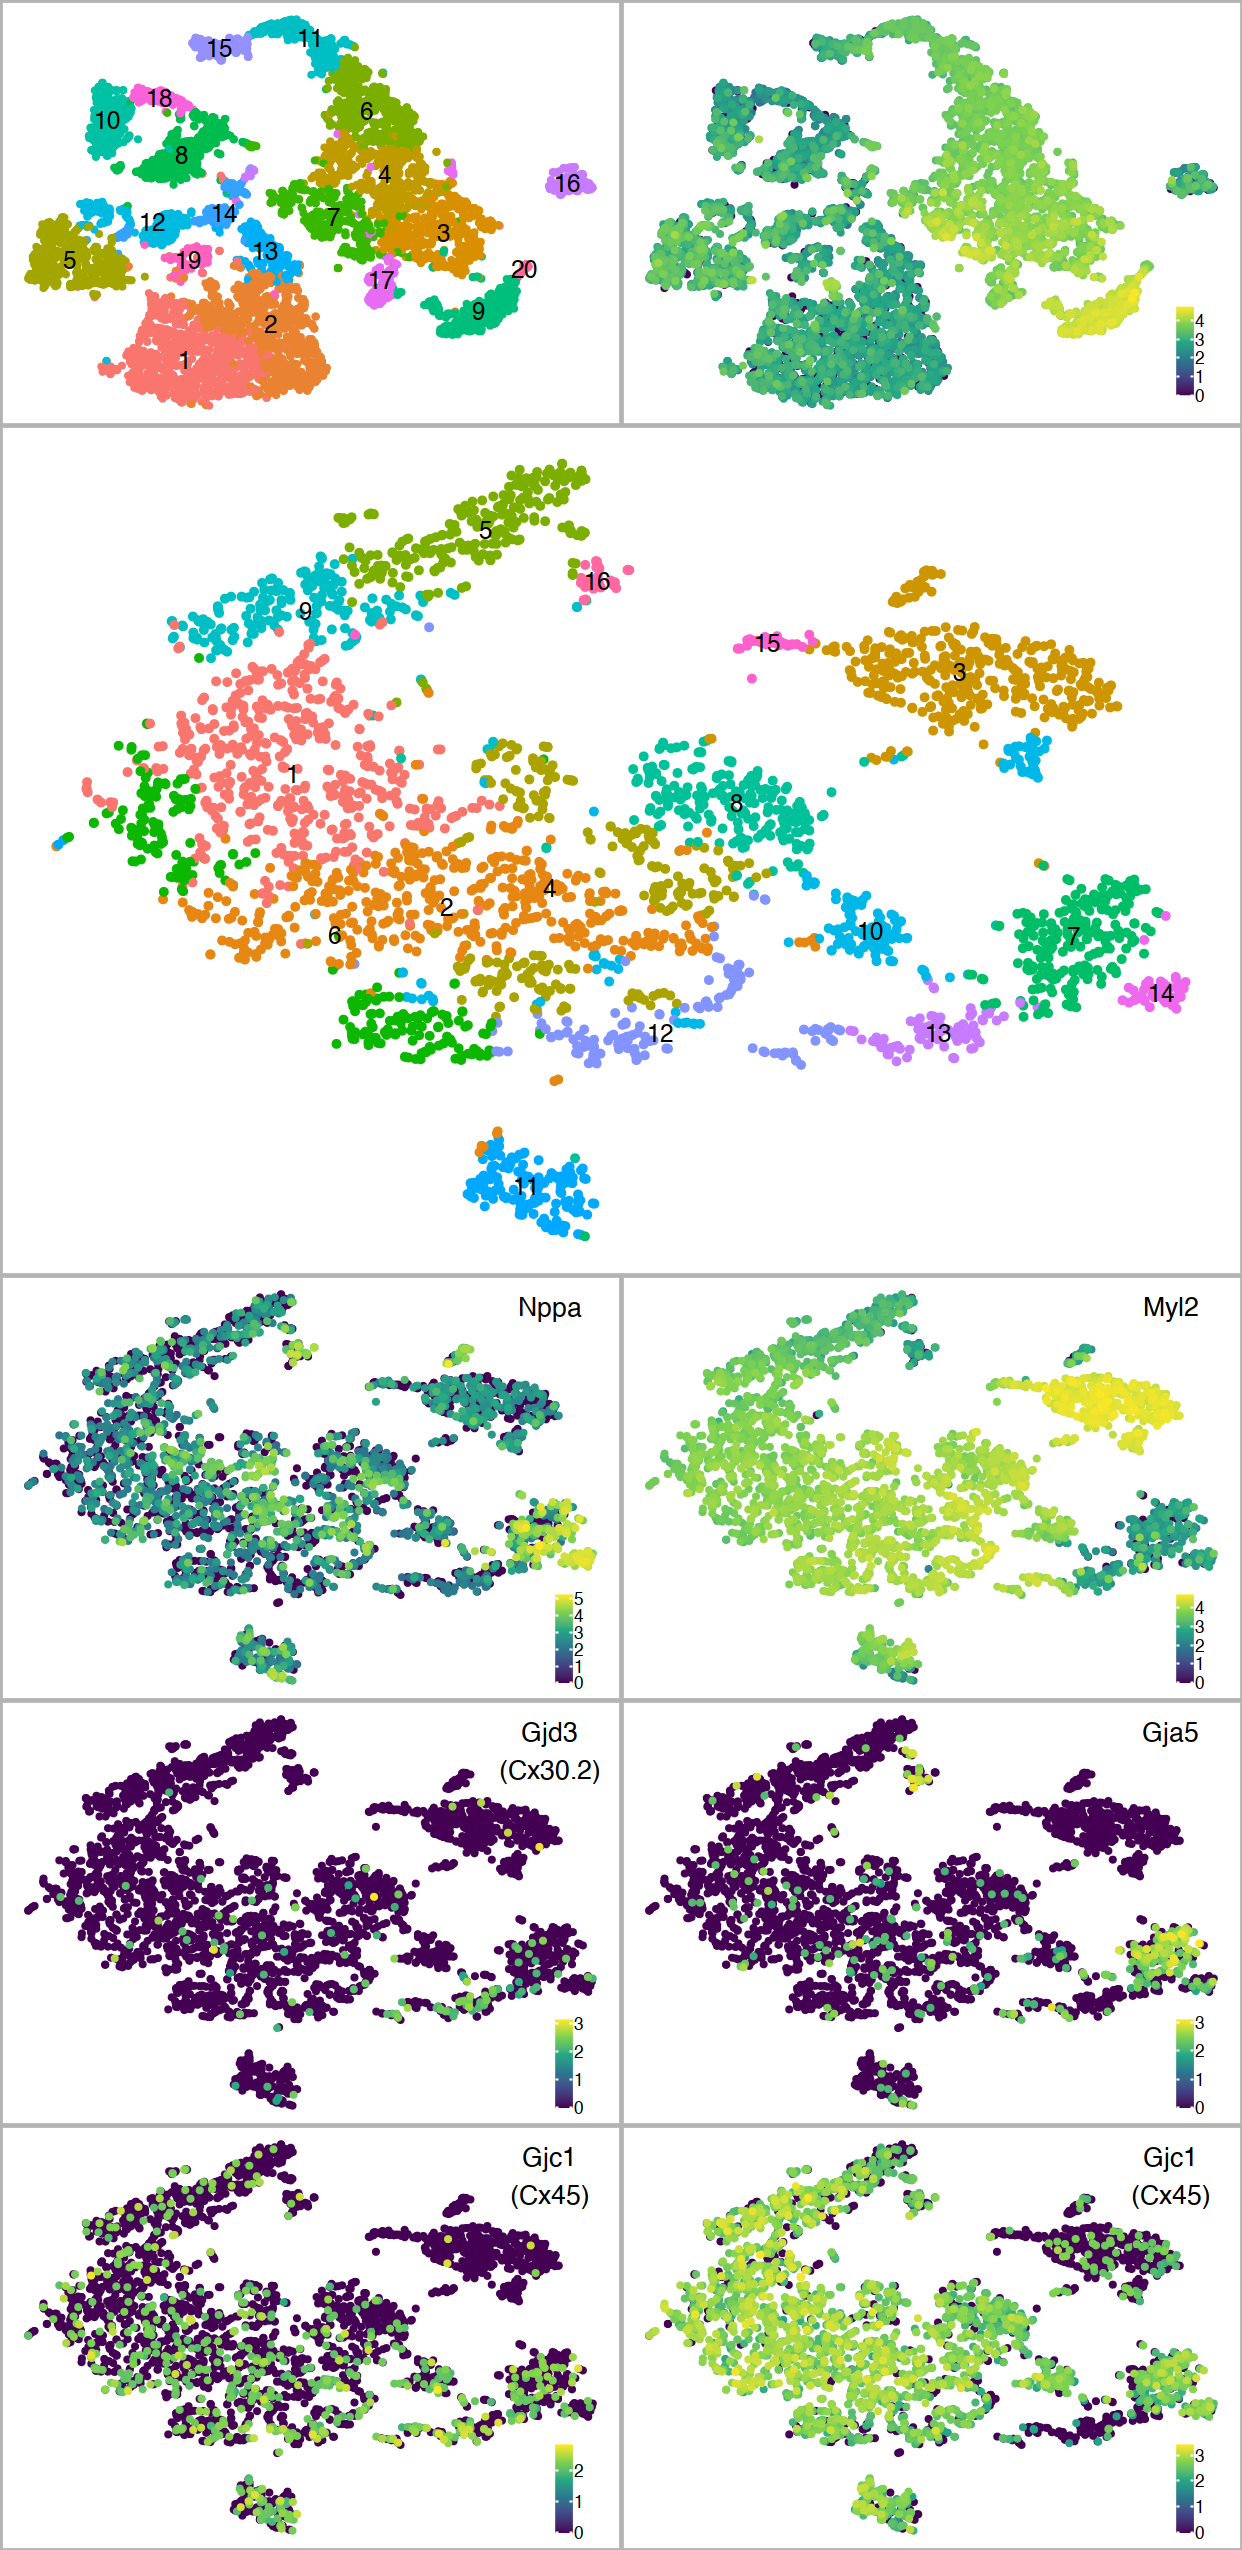

In [22]:
options(repr.plot.width = 4.14, repr.plot.height = 8.5, repr.plot.res = 300)

p_combined <- grid.arrange(
    grobs = list(
        p_embedding_clusters,
        p_embedding_Tnnt2,
        p_embedding_clusters_cms,
        p_embedding_Nppa,
        p_embedding_Myl2,
        p_embedding_Gjd3,
        p_embedding_Gja5,
        p_embedding_Gjc1,
        p_embedding_Gja1
    ),
    n = 2,
    layout_matrix = rbind(
        c(1, 2),
        c(3, 3),
        c(3, 3),
        c(4, 5),
        c(6, 7),
        c(8, 9)
    )
)

# R session information

In [23]:
if (require(devtools)) {
    session_info()
} else {
    sessionInfo()
}

Loading required package: devtools

Loading required package: usethis



─ Session info ───────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.0 (2020-04-24)
 os       macOS Catalina 10.15.4      
 system   x86_64, darwin19.4.0        
 ui       unknown                     
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/Chicago             
 date     2020-05-21                  

─ Packages ───────────────────────────────────────────────────────────────────
 package     * version     date       lib source                              
 assertthat    0.2.1       2019-03-21 [1] CRAN (R 4.0.0)                      
 backports     1.1.7       2020-05-13 [1] CRAN (R 4.0.0)                      
 base64enc     0.1-3       2015-07-28 [1] CRAN (R 4.0.0)                      
 broom         0.7.0.9000  2020-05-19 [1] Github (tidymodels/broom@5fc28ca)   
 Cairo         1.5-12      2020-04-11 [1] CRAN (R 4.0.0)